# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3231697/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3231697/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3231697/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-14 19:31:17,380] A new study created in RDB with name: no-name-cf561eab-ddba-4356-9e3a-fd54d22f8431
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:38,  3.13it/s]

current_loss: tensor(1.4806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4485094547271729
current_loss: tensor(1.4778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4405362606048584
current_loss: tensor(1.4715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149470329284668
current_loss: tensor(1.4616, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(1.4596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417878270149231
current_loss: tensor(1.4596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4152542352676392
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4152038097381592
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4153863191604614
current_loss: tensor(1.4581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169790744781494
Early Stop at iteration 7 with minimal loss tensor(1.4149, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:37,  9.17it/s]

current_loss: tensor(1.4606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3836337327957153
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3425816297531128


  0%|          | 3/2000 [00:00<03:50,  8.65it/s]

current_loss: tensor(1.3887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3135308027267456
current_loss: tensor(1.3624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:21,  9.90it/s]

current_loss_val:  1.30086088180542
current_loss: tensor(1.3504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2996758222579956
current_loss: tensor(1.3461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2990087270736694


  0%|          | 8/2000 [00:00<03:15, 10.21it/s]

current_loss: tensor(1.3441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2969141006469727
current_loss: tensor(1.3405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2943073511123657
current_loss: tensor(1.3372, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.3329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.288907527923584
current_loss: tensor(1.3329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2828315496444702
current_loss: tensor(1.3293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:08, 10.57it/s]

current_loss_val:  1.2792598009109497
current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275305986404419
current_loss: tensor(1.3228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271474838256836


  1%|          | 14/2000 [00:01<03:05, 10.68it/s]

current_loss: tensor(1.3215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713603973388672
current_loss: tensor(1.3186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712310552597046
current_loss: tensor(1.3181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:05, 10.72it/s]

current_loss: tensor(1.3166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705419063568115
current_loss: tensor(1.3166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698171138763428
current_loss: tensor(1.3154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:05, 10.69it/s]

current_loss_val:  1.2690305709838867
current_loss: tensor(1.3142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687058448791504
current_loss: tensor(1.3136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687125205993652


  1%|          | 22/2000 [00:02<03:03, 10.76it/s]

current_loss: tensor(1.3132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687382698059082
current_loss: tensor(1.3127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687889337539673
current_loss: tensor(1.3120, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:02, 10.82it/s]

current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684365510940552
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680606842041016
current_loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:05, 10.65it/s]

current_loss_val:  1.267640233039856
current_loss: tensor(1.3102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666651010513306
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655972242355347


  1%|▏         | 28/2000 [00:02<03:06, 10.60it/s]

current_loss: tensor(1.3081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263936161994934
current_loss: tensor(1.3070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622333765029907
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:06, 10.58it/s]

current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601960897445679
current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581430673599243
current_loss: tensor(1.3040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:04, 10.68it/s]

current_loss_val:  1.256300687789917
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559030055999756
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552275657653809


  2%|▏         | 36/2000 [00:03<03:08, 10.44it/s]

current_loss: tensor(1.3025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253957986831665
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539088726043701


  2%|▏         | 38/2000 [00:03<03:09, 10.33it/s]

current_loss: tensor(1.3014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253875732421875
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538034915924072
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:19,  9.81it/s]

current_loss: tensor(1.3012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538169622421265
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538447380065918
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:18,  9.85it/s]

current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540442943572998
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254221796989441
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:14, 10.08it/s]


current_loss_val:  1.2542009353637695
Early Stop at iteration 42 with minimal loss tensor(1.2538, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:25,346] Trial 0 finished with value: -2.5076069831848145 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.138470652689595, 'penalty_decorrelation_ridge_second_difference': 19.37626629546196}. Best is trial 0 with value: -2.5076069831848145.
  0%|          | 1/2000 [00:00<04:25,  7.53it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535603046417236
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533444166183472


  0%|          | 3/2000 [00:00<03:27,  9.61it/s]

current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514957189559937
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504466772079468
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250156283378601
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501188516616821
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:07, 10.60it/s]

current_loss_val:  1.2500853538513184
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498689889907837
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495359182357788


  1%|          | 11/2000 [00:01<03:05, 10.73it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249313235282898
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248874545097351
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:04, 10.77it/s]

current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248414158821106
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248444676399231
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:04, 10.79it/s]

current_loss_val:  1.2484701871871948
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485103607177734
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248691439628601


  1%|          | 16/2000 [00:01<03:19,  9.95it/s]


current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487549781799316
Early Stop at iteration 16 with minimal loss tensor(1.2484, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:27,535] Trial 1 finished with value: -2.496828079223633 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.32455668676952, 'penalty_decorrelation_ridge_second_difference': 21.21923630891108}. Best is trial 1 with value: -2.496828079223633.
  0%|          | 1/2000 [00:00<04:45,  7.00it/s]

current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537577152252197
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.45it/s]

current_loss_val:  1.2537095546722412
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533118724822998
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528570890426636


  0%|          | 5/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516870498657227
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:24,  9.76it/s]

current_loss_val:  1.2514654397964478
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514488697052002
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514832019805908


  0%|          | 10/2000 [00:01<03:16, 10.14it/s]

current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515276670455933
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514421939849854
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:14, 10.22it/s]

current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251291036605835
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251123309135437
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss_val:  1.250723123550415
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250678539276123
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507643699645996


  1%|          | 16/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511473894119263
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515654563903809
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514809370040894
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514375448226929
Early Stop at iteration 18 with minimal loss tensor(1.2507, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:29,979] Trial 2 finished with value: -2.501356840133667 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.776938143880171, 'penalty_decorrelation_ridge_second_difference': 29.106954186088558}. Best is trial 1 with value: -2.496828079223633.
  0%|          | 1/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527728080749512
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507323026657104
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.35it/s]

current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250274658203125
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250054955482483
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249661922454834
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494683265686035
current_loss: 

  0%|          | 7/2000 [00:00<03:33,  9.33it/s]

tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493089437484741
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249031662940979
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:22,  9.83it/s]

current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24905526638031
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249078631401062
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:11, 10.36it/s]

current_loss_val:  1.2489360570907593
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487274408340454
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482858896255493


  1%|          | 15/2000 [00:01<03:19,  9.97it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482928037643433
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483083009719849


  1%|          | 17/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248152256011963
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247721552848816
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:12, 10.28it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473158836364746
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469854354858398
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:09, 10.42it/s]

current_loss_val:  1.2456761598587036
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245501160621643
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453449964523315


  1%|          | 23/2000 [00:02<03:06, 10.58it/s]

current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452867031097412
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244335651397705
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:16, 10.05it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443151473999023
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443574666976929
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:13, 10.20it/s]

current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445489168167114
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445310354232788
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:07, 10.52it/s]

current_loss_val:  1.2441668510437012
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24384605884552
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437783479690552


  2%|▏         | 33/2000 [00:03<03:08, 10.42it/s]

current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434459924697876
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436892986297607
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:08, 10.40it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438044548034668
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440176010131836
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:17,  9.96it/s]


current_loss_val:  1.2441316843032837
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442160844802856
Early Stop at iteration 36 with minimal loss tensor(1.2434, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:34,246] Trial 3 finished with value: -2.486891984939575 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4223909202533676, 'penalty_decorrelation_ridge_second_difference': 7.513301246617078}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 2/2000 [00:00<03:31,  9.47it/s]

current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529023885726929
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518069744110107


  0%|          | 4/2000 [00:00<03:19, 10.02it/s]

current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250758171081543
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507483959197998
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.14it/s]

current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250739336013794
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508658170700073
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:13, 10.29it/s]

current_loss_val:  1.2507203817367554
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505955696105957
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504907846450806


  0%|          | 10/2000 [00:00<03:09, 10.49it/s]

current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491741180419922
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489778995513916
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:08, 10.54it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488006353378296
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483466863632202
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:08, 10.55it/s]

current_loss_val:  1.2480833530426025
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478950023651123
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:13, 10.23it/s]

current_loss_val:  1.2475826740264893
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468067407608032
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464416027069092


  1%|          | 20/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463182210922241
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462131977081299


  1%|          | 22/2000 [00:02<03:25,  9.62it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458064556121826
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245818018913269


  1%|          | 23/2000 [00:02<03:32,  9.30it/s]

current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458415031433105
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460911273956299


  1%|▏         | 25/2000 [00:02<03:27,  9.51it/s]

current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466949224472046
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464524507522583
Early Stop at iteration 25 with minimal loss tensor(1.2458, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:37,499] Trial 4 finished with value: -2.4916129112243652 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.139286461196175, 'penalty_decorrelation_ridge_second_difference': 2.70014457782201}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<05:09,  6.46it/s]

current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535086870193481
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.2532693147659302
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519630193710327
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513189315795898


  0%|          | 6/2000 [00:00<03:18, 10.03it/s]

current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509994506835938
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509547472000122
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250854253768921
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507297992706299
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:07, 10.60it/s]

current_loss_val:  1.2505093812942505
current_loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499139308929443
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.12it/s]

current_loss_val:  1.2496813535690308
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249606966972351
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493650913238525


  1%|          | 14/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490992546081543
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248950719833374
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489240169525146
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488231658935547
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:14, 10.16it/s]

current_loss_val:  1.248753547668457
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487257719039917
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485517263412476


  1%|          | 22/2000 [00:02<03:14, 10.18it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482367753982544
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480614185333252
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479724884033203
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478809356689453
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:18,  9.95it/s]

current_loss_val:  1.247843623161316
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478041648864746
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:14, 10.14it/s]

current_loss_val:  1.247744083404541
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476780414581299
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475816011428833


  2%|▏         | 30/2000 [00:02<03:10, 10.33it/s]

current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474912405014038
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475053071975708
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:08, 10.41it/s]

current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475334405899048
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475119829177856
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:06, 10.53it/s]

current_loss_val:  1.2474350929260254
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247347116470337
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:13, 10.12it/s]

current_loss_val:  1.247315526008606
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473053932189941
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473167181015015
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247330904006958


  2%|▏         | 40/2000 [00:04<04:08,  7.87it/s]

current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472984790802002
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247233271598816
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:49,  8.54it/s]

current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472281455993652
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472094297409058
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:40,  8.87it/s]

current_loss_val:  1.2471752166748047
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471479177474976
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:27,  9.41it/s]

current_loss_val:  1.247143030166626
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247157096862793
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247265100479126


  2%|▏         | 49/2000 [00:05<03:17,  9.86it/s]

current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472549676895142
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472739219665527
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:23,  9.60it/s]


current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247300386428833
Early Stop at iteration 50 with minimal loss tensor(1.2471, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:43,304] Trial 5 finished with value: -2.494286060333252 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.339185217921752, 'penalty_decorrelation_ridge_second_difference': 13.538766059940455}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:40,  7.14it/s]

current_loss: tensor(1.2950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253787636756897
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.43it/s]

current_loss_val:  1.253767728805542
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253574013710022
current_loss: tensor(1.2945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533150911331177


  0%|          | 6/2000 [00:00<03:33,  9.33it/s]

current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252551555633545
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525005340576172


  0%|          | 8/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252562165260315
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529630661010742
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:15, 10.15it/s]

current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531859874725342
current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531297206878662
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2916, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:41,  8.98it/s]


current_loss_val:  1.2530101537704468
Early Stop at iteration 10 with minimal loss tensor(1.2525, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:45,062] Trial 6 finished with value: -2.5050010681152344 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.33441530744992, 'penalty_decorrelation_ridge_second_difference': 25.12893731875644}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:58,  6.69it/s]

current_loss: tensor(1.2955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537628412246704
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:31,  9.45it/s]

current_loss_val:  1.2537245750427246
current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533667087554932
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529895305633545


  0%|          | 6/2000 [00:00<03:19, 10.00it/s]

current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523269653320312
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524490356445312
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524964809417725
current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252610206604004
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:49,  8.66it/s]

current_loss_val:  1.252882719039917
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252921223640442
Early Stop at iteration 9 with minimal loss tensor(1.2523, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:46,724] Trial 7 finished with value: -2.5046536922454834 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.454151486754903, 'penalty_decorrelation_ridge_second_difference': 19.00535390692399}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<03:33,  9.36it/s]

current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528703212738037
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252116084098816
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250793218612671
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506201267242432
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.43it/s]

current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504196166992188
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503900527954102
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:35,  9.26it/s]

current_loss_val:  1.2504364252090454
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504785060882568
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:22,  9.85it/s]

current_loss_val:  1.250441074371338
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503172159194946
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498259544372559


  1%|          | 12/2000 [00:01<03:16, 10.11it/s]

current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249114990234375
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488188743591309
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481858730316162
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475178241729736
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:12, 10.29it/s]

current_loss_val:  1.2476210594177246
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477182149887085
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:27,  9.54it/s]

current_loss_val:  1.2478294372558594
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478376626968384
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479572296142578
Early Stop at iteration 19 with minimal loss tensor(1.2475, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:49,470] Trial 8 finished with value: -2.495035409927368 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.497436149526519, 'penalty_decorrelation_ridge_second_difference': 2.3279497780835596}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:39,  7.16it/s]

current_loss: tensor(1.2978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253822684288025
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:26,  9.69it/s]

current_loss_val:  1.2538334131240845
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253878116607666
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538783550262451


  0%|          | 5/2000 [00:00<04:07,  8.07it/s]


current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540184259414673
current_loss: tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541834115982056
Early Stop at iteration 5 with minimal loss tensor(1.2538, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:50,669] Trial 9 finished with value: -2.50764536857605 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.149814506498295, 'penalty_decorrelation_ridge_second_difference': 27.4187282704854}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253880500793457
current_loss: tensor(1.3032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253942847251892


  0%|          | 3/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545254230499268
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551984786987305
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:11,  7.94it/s]

current_loss: tensor(1.3009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256018042564392
current_loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565139532089233
Early Stop at iteration 5 with minimal loss tensor(1.2539, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:51,898] Trial 10 finished with value: -2.507761001586914 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.21034447058173, 'penalty_decorrelation_ridge_second_difference': 27.11559830923233}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:57,  6.71it/s]

current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538597583770752
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:26,  9.66it/s]

current_loss_val:  1.2539061307907104
current_loss: tensor(1.3017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544292211532593
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550950050354004


  0%|          | 5/2000 [00:00<04:08,  8.03it/s]


current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256205439567566
current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255929708480835
Early Stop at iteration 5 with minimal loss tensor(1.2539, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:53,233] Trial 11 finished with value: -2.5077197551727295 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.019108570867907, 'penalty_decorrelation_ridge_second_difference': 18.200381126480572}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 2/2000 [00:00<03:30,  9.51it/s]

current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528694868087769
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512595653533936


  0%|          | 4/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504336833953857
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504467964172363
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:08, 10.60it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505574226379395
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510262727737427
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:38,  9.12it/s]


current_loss_val:  1.250955581665039
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508909702301025
Early Stop at iteration 7 with minimal loss tensor(1.2504, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:31:54,785] Trial 12 finished with value: -2.5008673667907715 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.542777566857262, 'penalty_decorrelation_ridge_second_difference': 4.215353133495572}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:42,  7.07it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253466248512268
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.11it/s]

current_loss_val:  1.253173828125
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509534358978271
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499823570251465


  0%|          | 6/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249896764755249
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498825788497925


  0%|          | 8/2000 [00:00<03:19,  9.99it/s]

current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498273849487305
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496087551116943
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492753267288208
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489031553268433
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:10, 10.42it/s]

current_loss_val:  1.248477816581726
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480698823928833
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248118281364441


  1%|          | 14/2000 [00:01<03:08, 10.55it/s]

current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481539249420166
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248224139213562
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:31,  9.38it/s]

current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482784986495972
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248293399810791
Early Stop at iteration 16 with minimal loss tensor(1.2481, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:57,230] Trial 13 finished with value: -2.4961392879486084 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.75001915005173, 'penalty_decorrelation_ridge_second_difference': 19.833688517260047}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537764310836792
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:28,  9.59it/s]

current_loss_val:  1.2537510395050049
current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535078525543213
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532958984375


  0%|          | 5/2000 [00:00<03:14, 10.24it/s]

current_loss: tensor(1.2954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532168626785278
current_loss: tensor(1.2951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533494234085083
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:12, 10.33it/s]

current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534046173095703
current_loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538273334503174
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:44,  8.86it/s]

current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538374662399292
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537596225738525
Early Stop at iteration 9 with minimal loss tensor(1.2532, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:31:58,992] Trial 14 finished with value: -2.5064334869384766 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.104153106094774, 'penalty_decorrelation_ridge_second_difference': 16.92235471662702}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 2/2000 [00:00<03:39,  9.09it/s]

current_loss: tensor(1.3010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536624670028687
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536005973815918


  0%|          | 4/2000 [00:00<03:23,  9.78it/s]

current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25369393825531
current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537732124328613
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:36,  9.22it/s]

current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542707920074463
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548056840896606
current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:09,  8.00it/s]


current_loss: tensor(1.2960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549608945846558
Early Stop at iteration 6 with minimal loss tensor(1.2536, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:00,569] Trial 15 finished with value: -2.5072011947631836 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.825969457282287, 'penalty_decorrelation_ridge_second_difference': 0.879571748667733}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 1/2000 [00:00<03:49,  8.72it/s]

current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527949810028076
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25133216381073


  0%|          | 3/2000 [00:00<03:46,  8.83it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508968114852905
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249976634979248
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:28,  9.56it/s]

current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499607801437378
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249890685081482
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:13, 10.30it/s]

current_loss_val:  1.2498018741607666
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249723196029663
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496037483215332


  1%|          | 11/2000 [00:01<03:10, 10.44it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492293119430542
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248713731765747
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:09, 10.49it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484129667282104
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475504875183105
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:29,  9.47it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472760677337646
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247247338294983
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:31,  9.35it/s]

current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24699068069458
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468913793563843
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:23,  9.75it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467988729476929
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463713884353638
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:16, 10.07it/s]

current_loss_val:  1.246256709098816
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246134638786316
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461140155792236


  1%|          | 23/2000 [00:02<03:14, 10.18it/s]

current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245984435081482
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458267211914062
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:12, 10.24it/s]

current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457083463668823
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455884218215942
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:07, 10.52it/s]

current_loss_val:  1.2453571557998657
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452147006988525
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449105978012085


  2%|▏         | 31/2000 [00:03<03:08, 10.46it/s]

current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244635820388794
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244603157043457
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:05, 10.60it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244611382484436
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446202039718628
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:18,  9.90it/s]

current_loss_val:  1.244659185409546
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446978092193604
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446486949920654
Early Stop at iteration 35 with minimal loss tensor(1.2446, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:04,812] Trial 16 finished with value: -2.489206314086914 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8514741009281004, 'penalty_decorrelation_ridge_second_difference': 9.82613008632012}. Best is trial 3 with value: -2.486891984939575.
  0%|          | 2/2000 [00:00<03:07, 10.65it/s]

current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252759575843811
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508735656738281
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504040002822876
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499346733093262
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496942281723022
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495074272155762
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:10, 10.45it/s]

current_loss_val:  1.2492079734802246
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491724491119385
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490793466567993


  0%|          | 10/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489053010940552
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487229108810425
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:07, 10.61it/s]

current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248651146888733
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485545873641968
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:05, 10.70it/s]

current_loss_val:  1.2484989166259766
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484151124954224
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:10, 10.42it/s]

current_loss_val:  1.2482593059539795
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481210231781006
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477200031280518


  1%|          | 20/2000 [00:01<03:07, 10.57it/s]

current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472974061965942
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246571660041809
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:05, 10.68it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464492321014404
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464579343795776
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:15, 10.10it/s]

current_loss_val:  1.2464302778244019
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464226484298706
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:12, 10.28it/s]

current_loss_val:  1.2463971376419067
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463773488998413
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463492155075073


  1%|▏         | 28/2000 [00:02<03:08, 10.47it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463091611862183
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462912797927856
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:05, 10.60it/s]

current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462162971496582
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460966110229492
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:02, 10.75it/s]

current_loss_val:  1.2460994720458984
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461081743240356
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461137771606445


  2%|▏         | 36/2000 [00:03<03:02, 10.75it/s]

current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460840940475464
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246070384979248
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:02, 10.74it/s]

current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460521459579468
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459641695022583
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:01, 10.80it/s]

current_loss_val:  1.2459440231323242
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459509372711182
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245948314666748


  2%|▏         | 42/2000 [00:03<03:01, 10.81it/s]

current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459251880645752
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245798945426941
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:00, 10.82it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456459999084473
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245369553565979
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:00, 10.83it/s]

current_loss_val:  1.2451319694519043
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448281049728394
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<03:08, 10.36it/s]

current_loss_val:  1.244276762008667
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436600923538208
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435944080352783


  3%|▎         | 52/2000 [00:04<03:15,  9.97it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24339759349823
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243366003036499


  3%|▎         | 54/2000 [00:05<03:11, 10.18it/s]

current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243363618850708
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433580160140991
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:05<03:18,  9.79it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433384656906128
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433274984359741
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:05<03:12, 10.11it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433198690414429
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432974576950073
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<03:19,  9.74it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432940006256104
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432907819747925
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:05<03:12, 10.07it/s]

current_loss_val:  1.243249773979187
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431843280792236
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431693077087402


  3%|▎         | 64/2000 [00:06<03:08, 10.28it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431588172912598
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431416511535645
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:06<03:05, 10.45it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431273460388184
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431071996688843
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:06<03:01, 10.64it/s]

current_loss_val:  1.2431038618087769
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431060075759888
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431108951568604


  4%|▎         | 72/2000 [00:06<03:10, 10.13it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431246042251587
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431379556655884


  4%|▎         | 72/2000 [00:07<03:08, 10.25it/s]


current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243165373802185
Early Stop at iteration 72 with minimal loss tensor(1.2431, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:12,479] Trial 17 finished with value: -2.4862074851989746 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.41663396448130907, 'penalty_decorrelation_ridge_second_difference': 8.845865319900655}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253219485282898
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531182765960693
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:05, 10.73it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529417276382446
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526720762252808
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:05, 10.73it/s]

current_loss_val:  1.251227855682373
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508753538131714
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509334087371826


  0%|          | 8/2000 [00:00<03:04, 10.81it/s]

current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509965896606445
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511165142059326
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:31,  9.39it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513433694839478
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251493215560913
Early Stop at iteration 10 with minimal loss tensor(1.2509, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:14,121] Trial 18 finished with value: -2.5017502307891846 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.48727343533025, 'penalty_decorrelation_ridge_second_difference': 10.128228970346745}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:30,  9.50it/s]

current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253037929534912
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529116868972778


  0%|          | 4/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526861429214478
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523503303527832
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:35,  9.26it/s]

current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505998611450195
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503184080123901
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250232458114624
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499418258666992
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:16, 10.11it/s]

current_loss_val:  1.2497620582580566
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496025562286377
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494862079620361


  1%|          | 12/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491987943649292
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248805046081543
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.45it/s]

current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485240697860718
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484169006347656
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:06, 10.65it/s]

current_loss_val:  1.2476052045822144
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474119663238525
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474149465560913


  1%|          | 20/2000 [00:01<03:05, 10.67it/s]

current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475337982177734
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247728943824768
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:20,  9.87it/s]


current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247721552848816
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476866245269775
Early Stop at iteration 21 with minimal loss tensor(1.2474, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:16,826] Trial 19 finished with value: -2.494823455810547 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.4322775746742025, 'penalty_decorrelation_ridge_second_difference': 13.150552948429914}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:33,  9.36it/s]

current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528116703033447
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514328956604004


  0%|          | 4/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508821487426758
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500370740890503
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250022053718567
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499549388885498
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:11, 10.38it/s]

current_loss_val:  1.2498681545257568
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497847080230713
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496616840362549


  1%|          | 11/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492755651474
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487729787826538
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:06, 10.65it/s]

current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248475432395935
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476379871368408
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247413992881775
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472858428955078
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:19,  9.93it/s]

current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470697164535522
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246921181678772
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:13, 10.23it/s]

current_loss_val:  1.2468124628067017
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246816873550415
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468372583389282


  1%|          | 21/2000 [00:02<03:20,  9.87it/s]

current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468594312667847
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468615770339966


  1%|          | 22/2000 [00:02<03:24,  9.65it/s]


current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468823194503784
Early Stop at iteration 22 with minimal loss tensor(1.2468, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:19,693] Trial 20 finished with value: -2.4936249256134033 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3098215851192683, 'penalty_decorrelation_ridge_second_difference': 9.775125828104812}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:35,  9.27it/s]

current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252750277519226
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506338357925415


  0%|          | 3/2000 [00:00<03:57,  8.42it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250207781791687
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249955415725708


  0%|          | 5/2000 [00:00<03:26,  9.67it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496153116226196
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490522861480713
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248793601989746


  0%|          | 8/2000 [00:01<04:49,  6.87it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488480806350708
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249298095703125
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:09,  7.96it/s]

current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491967678070068
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489742040634155
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:58,  8.34it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483062744140625
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478244304656982
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:25,  9.63it/s]

current_loss_val:  1.2471470832824707
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246765375137329
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466102838516235


  1%|          | 18/2000 [00:01<03:18,  9.98it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465530633926392
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465715408325195
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:23,  9.72it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246644139289856
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246742606163025
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:43,  8.85it/s]


current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468044757843018
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247039794921875
Early Stop at iteration 21 with minimal loss tensor(1.2466, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:22,660] Trial 21 finished with value: -2.493105888366699 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6390752554837021, 'penalty_decorrelation_ridge_second_difference': 7.9133698391816365}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252652645111084
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527157068252563
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.81it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501273155212402
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499217987060547
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:03, 10.84it/s]

current_loss_val:  1.249579668045044
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248883605003357
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493189573287964


  0%|          | 8/2000 [00:00<03:03, 10.85it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498135566711426
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249529480934143
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.90it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493103742599487
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489233016967773
Early Stop at iteration 10 with minimal loss tensor(1.2489, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:24,257] Trial 22 finished with value: -2.4977669715881348 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.12273487334408306, 'penalty_decorrelation_ridge_second_difference': 3.7897498235236124}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<03:34,  9.33it/s]

current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529126405715942
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526607513427734
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520897388458252
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25143301486969
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:26,  9.66it/s]

current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250369906425476
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499924898147583
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:15, 10.18it/s]

current_loss_val:  1.2496685981750488
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249384880065918
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490969896316528


  1%|          | 11/2000 [00:01<03:11, 10.38it/s]

current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488406896591187
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485988140106201
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.55it/s]

current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484040260314941
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479881048202515
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:15, 10.13it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476967573165894
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475061416625977
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:10, 10.40it/s]

current_loss_val:  1.246972680091858
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466893196105957
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464834451675415


  1%|          | 19/2000 [00:01<03:11, 10.35it/s]

current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461594343185425
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245933175086975
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:08, 10.51it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456536293029785
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453299760818481
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:04, 10.69it/s]

current_loss_val:  1.2451735734939575
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450443506240845
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446491718292236


  1%|▏         | 27/2000 [00:02<03:04, 10.67it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443770170211792
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244195818901062
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:03, 10.73it/s]

current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244038701057434
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243903636932373
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:02, 10.77it/s]

current_loss_val:  1.2437340021133423
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24366295337677
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436718940734863


  2%|▏         | 33/2000 [00:03<03:01, 10.83it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436844110488892
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437825202941895
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:12, 10.23it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439732551574707
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440437078475952
Early Stop at iteration 35 with minimal loss tensor(1.2437, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:28,264] Trial 23 finished with value: -2.487325668334961 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5577754814469493, 'penalty_decorrelation_ridge_second_difference': 14.532273191901076}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<03:27,  9.65it/s]

current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528451681137085
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252284049987793
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504897117614746
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249818205833435
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:10, 10.44it/s]

current_loss_val:  1.2496812343597412
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249597191810608
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24951171875


  0%|          | 9/2000 [00:00<03:07, 10.61it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493761777877808
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249258041381836
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:06, 10.69it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490804195404053
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485637664794922
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:04, 10.75it/s]

current_loss_val:  1.2482380867004395
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480429410934448
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477068901062012


  1%|          | 15/2000 [00:01<03:03, 10.82it/s]

current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473549842834473
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247132658958435
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:03, 10.81it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470077276229858
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246781587600708
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<03:03, 10.80it/s]

current_loss_val:  1.2463953495025635
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463489770889282
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463457584381104


  1%|          | 23/2000 [00:02<03:02, 10.84it/s]

current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463359832763672
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463374137878418
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:02, 10.85it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463279962539673
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246310830116272
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:01, 10.84it/s]

current_loss_val:  1.2462844848632812
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462559938430786
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462326288223267


  1%|▏         | 29/2000 [00:02<03:01, 10.85it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461721897125244
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461228370666504
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:02, 10.79it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460845708847046
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460482120513916
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:07, 10.50it/s]

current_loss_val:  1.2459908723831177
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459617853164673
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245939016342163


  2%|▏         | 37/2000 [00:03<03:06, 10.52it/s]

current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459087371826172
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245844841003418
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:05, 10.60it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455971240997314
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453056573867798
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<03:03, 10.68it/s]

current_loss_val:  1.2451893091201782
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245136022567749
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449710369110107


  2%|▏         | 43/2000 [00:04<03:02, 10.71it/s]

current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447872161865234
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244613528251648
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:02, 10.73it/s]

current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444243431091309
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441890239715576
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:05, 10.53it/s]

current_loss_val:  1.2440232038497925
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439732551574707
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<03:12, 10.12it/s]

current_loss_val:  1.243988275527954
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244028091430664
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440783977508545


  3%|▎         | 52/2000 [00:05<03:07, 10.38it/s]


current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440192699432373
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440096139907837
Early Stop at iteration 52 with minimal loss tensor(1.2440, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:33,885] Trial 24 finished with value: -2.4879462718963623 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3044706562104753, 'penalty_decorrelation_ridge_second_difference': 13.553087884193596}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<03:41,  9.02it/s]

current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532223463058472
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526543140411377


  0%|          | 3/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518603801727295
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516497373580933
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25163996219635
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515732049942017
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:09, 10.49it/s]

current_loss_val:  1.2514455318450928
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513325214385986
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513554096221924


  1%|          | 11/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510437965393066
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25107741355896
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.51it/s]

current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511600255966187
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513612508773804
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.74it/s]


current_loss_val:  1.251340389251709
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513493299484253
Early Stop at iteration 14 with minimal loss tensor(1.2510, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:35,940] Trial 25 finished with value: -2.502087354660034 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.123500244507776, 'penalty_decorrelation_ridge_second_difference': 4.908064795391115}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<05:15,  6.34it/s]

current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253614068031311
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:57,  8.42it/s]

current_loss_val:  1.2534526586532593
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252318263053894
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:34,  9.30it/s]

current_loss_val:  1.2515314817428589
current_loss: tensor(1.2888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510056495666504
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:28,  9.58it/s]

current_loss_val:  1.2510247230529785
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510638236999512
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512383460998535


  0%|          | 9/2000 [00:01<03:57,  8.40it/s]

current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512685060501099
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251130223274231
Early Stop at iteration 9 with minimal loss tensor(1.2510, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:37,616] Trial 26 finished with value: -2.502011299133301 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.171637443379256, 'penalty_decorrelation_ridge_second_difference': 16.011941507738083}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<04:40,  7.13it/s]

current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536721229553223
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:30,  9.49it/s]

current_loss_val:  1.253554344177246
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25258469581604
current_loss: tensor(1.2891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517989873886108


  0%|          | 6/2000 [00:00<03:27,  9.61it/s]

current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510112524032593
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510067224502563


  0%|          | 7/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510408163070679
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512083053588867
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:21,  9.87it/s]

current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251139521598816
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507915496826172
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:18, 10.01it/s]

current_loss_val:  1.2506279945373535
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503552436828613
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499455213546753


  1%|          | 15/2000 [00:01<03:23,  9.74it/s]

current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249826192855835
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249796748161316


  1%|          | 17/2000 [00:01<03:18,  9.99it/s]

current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499072551727295
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249900460243225
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:14, 10.19it/s]

current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498290538787842
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496687173843384
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:11, 10.31it/s]

current_loss_val:  1.2495325803756714
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492642402648926
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489620447158813


  1%|          | 23/2000 [00:02<03:09, 10.42it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488579750061035
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488598823547363
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:08, 10.49it/s]

current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488700151443481
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488871812820435
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:25,  9.59it/s]

current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488778829574585
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248865008354187
Early Stop at iteration 27 with minimal loss tensor(1.2489, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 19:32:40,940] Trial 27 finished with value: -2.497715711593628 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.453007324054969, 'penalty_decorrelation_ridge_second_difference': 19.725364796800736}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 2/2000 [00:00<03:39,  9.09it/s]

current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529761791229248
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528046369552612


  0%|          | 4/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252478837966919
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520469427108765
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.26it/s]

current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250085473060608
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499207258224487
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:11, 10.41it/s]

current_loss_val:  1.249925136566162
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499148845672607
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498939037322998


  0%|          | 10/2000 [00:01<03:23,  9.80it/s]

current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499083280563354
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499207258224487


  1%|          | 12/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499146461486816
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496840953826904
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494274377822876
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492468357086182
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:06, 10.63it/s]

current_loss_val:  1.2488218545913696
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247799277305603
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474786043167114


  1%|          | 20/2000 [00:01<03:04, 10.70it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473572492599487
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471680641174316
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468008995056152
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465176582336426
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:10, 10.35it/s]

current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463868856430054
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463008165359497
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:17, 10.00it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246150016784668
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24604070186615
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:11, 10.29it/s]

current_loss_val:  1.2459239959716797
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457407712936401
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456226348876953


  2%|▏         | 30/2000 [00:02<03:08, 10.46it/s]

current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455878257751465
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245322823524475
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:06, 10.57it/s]

current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451555728912354
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451066970825195
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:04, 10.67it/s]

current_loss_val:  1.2451026439666748
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450588941574097
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245065689086914


  2%|▏         | 38/2000 [00:03<03:02, 10.76it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450828552246094
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245082139968872
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:13, 10.16it/s]


current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450950145721436
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451001405715942
Early Stop at iteration 39 with minimal loss tensor(1.2451, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:45,331] Trial 28 finished with value: -2.4901177883148193 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.4692032658076064, 'penalty_decorrelation_ridge_second_difference': 13.943181844346626}. Best is trial 17 with value: -2.4862074851989746.
  0%|          | 1/2000 [00:00<03:36,  9.23it/s]

current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530701160430908
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527267932891846
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518153190612793
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510795593261719
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:14, 10.25it/s]

current_loss_val:  1.2506479024887085
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505525350570679
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505966424942017


  0%|          | 9/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506990432739258
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250800609588623
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:31,  9.40it/s]


current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507996559143066
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507754564285278
Early Stop at iteration 10 with minimal loss tensor(1.2506, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 19:32:46,944] Trial 29 finished with value: -2.501105308532715 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.752118525612263, 'penalty_decorrelation_ridge_second_difference': 10.104623138082717}. Best is trial 17 with value: -2.4862074851989746.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:41, 24.19it/s]

current_loss: tensor(1.4616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:40, 24.69it/s]

current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:39, 24.81it/s]

current_loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:45, 21.82it/s]

current_loss: tensor(1.4575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.3052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:44, 22.14it/s]

current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:45, 21.58it/s]

current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:46, 21.26it/s]

current_loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:44, 21.69it/s]

current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:45, 21.24it/s]

current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:44, 21.61it/s]

current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 33/1000 [00:01<00:43, 22.43it/s]

tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:43, 22.06it/s]

current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:50, 19.06it/s]

current_loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:52, 18.34it/s]

current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:02<00:51, 18.45it/s]

current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:02<00:51, 18.52it/s]

current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:02<00:58, 16.20it/s]

current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:02<00:56, 16.82it/s]

current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<00:50, 18.60it/s]

current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  6%|▌         | 55/1000 [00:02<00:47, 20.02it/s]

tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:02<00:50, 18.52it/s]

current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:03<00:47, 19.66it/s]

current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:03<00:45, 20.48it/s]

current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:03<00:50, 18.45it/s]

current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:03<00:50, 18.37it/s]

current_loss: tensor(1.4554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  7%|▋         | 72/1000 [00:03<00:47, 19.42it/s]

tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:03<00:45, 20.13it/s]

current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  8%|▊         | 78/1000 [00:03<00:46, 19.83it/s]

tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:04<00:44, 20.54it/s]

current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:04<00:45, 20.15it/s]

current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:04<00:44, 20.56it/s]

current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:04<00:43, 20.88it/s]

current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:04<00:46, 19.66it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:04<00:48, 18.69it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:04<00:44, 20.29it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 101/1000 [00:05<01:16, 11.70it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 103/1000 [00:05<01:45,  8.48it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 104/1000 [00:06<00:53, 16.62it/s]

current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 104 with minimal loss tensor(1.4550, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:57,  8.49it/s]

current_loss_val:  1.3820164203643799
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:54,  8.68it/s]

current_loss_val:  1.3235654830932617
current_loss: tensor(1.3478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:03,  8.07it/s]

current_loss: tensor(1.3346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.312129020690918
current_loss: tensor(1.3346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3024612665176392
current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:47,  9.22it/s]

current_loss_val:  1.2985827922821045
current_loss: tensor(1.3219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.29271399974823
current_loss: tensor(1.3153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:44,  9.50it/s]

current_loss_val:  1.2866216897964478
current_loss: tensor(1.3116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285381555557251
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:41,  9.79it/s]

current_loss: tensor(1.3062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2857686281204224
current_loss: tensor(1.3062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2861006259918213
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<01:38, 10.05it/s]

current_loss_val:  1.2847063541412354
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:36, 10.21it/s]

current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2794559001922607
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273719310760498
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:35, 10.27it/s]

current_loss_val:  1.2712059020996094
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271036982536316
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707360982894897


  2%|▏         | 17/1000 [00:01<01:35, 10.34it/s]

current_loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702696323394775
current_loss: tensor(1.2930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268937110900879
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:34, 10.34it/s]

current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685271501541138
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680459022521973
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:02<01:36, 10.18it/s]

current_loss_val:  1.2669802904129028
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666245698928833


  2%|▏         | 23/1000 [00:02<01:35, 10.18it/s]

current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266546607017517
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662965059280396


  2%|▎         | 25/1000 [00:02<02:02,  7.94it/s]

current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654942274093628
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639838457107544
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:54,  8.53it/s]

current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629714012145996
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603212594985962
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:03<01:43,  9.35it/s]

current_loss_val:  1.259326457977295
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581429481506348
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569310665130615
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557262182235718
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:03<01:41,  9.55it/s]

current_loss_val:  1.2545181512832642
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537825107574463
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504500150680542


  4%|▎         | 36/1000 [00:03<01:46,  9.03it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505062818527222
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:04<01:43,  9.33it/s]

current_loss_val:  1.2504898309707642
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504961490631104
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:04<01:49,  8.79it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250325083732605
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501429319381714
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:04<01:40,  9.51it/s]

current_loss_val:  1.250107765197754
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501509189605713
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25034499168396


  4%|▍         | 44/1000 [00:04<01:46,  9.00it/s]

current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250388503074646
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:04<01:44,  9.18it/s]

current_loss_val:  1.250376582145691
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504075765609741
Early Stop at iteration 45 with minimal loss tensor(1.2501, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [21]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 20,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =1.0,
                tau_vi_sigma_init = 0.15,
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 1/800 [00:04<59:41,  4.48s/it]


Iteration [1/800] train=12.5322    val_ELPD=-0.0409  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18068  τ₁≈5.3482  τ₂≈10.909  |  (EB targets) τ₄*≈0.5351  τ₁*≈118.6  τ₂*≈163.82
E_qf_total≈37.3703  E_qf1≈0.3099  E_qf2≈0.3018
[monitor] τ₄·E_qf≈6.75  target≈20.00 | τ₁·E_qf1≈1.66  target≈36.76 | τ₂·E_qf2≈3.29  target≈49.44
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:08<59:15,  4.46s/it]


Iteration [2/800] train=12.4022    val_ELPD=-0.0399  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15977  τ₁≈5.2243  τ₂≈10.752  |  (EB targets) τ₄*≈0.53788  τ₁*≈118.01  τ₂*≈163.83
E_qf_total≈37.1766  E_qf1≈0.3135  E_qf2≈0.3017
[monitor] τ₄·E_qf≈5.94  target≈20.00 | τ₁·E_qf1≈1.64  target≈36.99 | τ₂·E_qf2≈3.24  target≈49.43
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:13<59:05,  4.45s/it]


Iteration [3/800] train=12.2188    val_ELPD=-0.0394  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1447  τ₁≈5.1137  τ₂≈10.597  |  (EB targets) τ₄*≈0.54051  τ₁*≈116.78  τ₂*≈162.73
E_qf_total≈36.9959  E_qf1≈0.3210  E_qf2≈0.3051
[monitor] τ₄·E_qf≈5.35  target≈20.00 | τ₁·E_qf1≈1.64  target≈37.49 | τ₂·E_qf2≈3.23  target≈49.65
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:17<58:45,  4.43s/it]


Iteration [4/800] train=12.0806    val_ELPD=-0.0389  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1296  τ₁≈4.9635  τ₂≈10.491  |  (EB targets) τ₄*≈0.54298  τ₁*≈115.68  τ₂*≈162.05
E_qf_total≈36.8274  E_qf1≈0.3279  E_qf2≈0.3073
[monitor] τ₄·E_qf≈4.77  target≈20.00 | τ₁·E_qf1≈1.63  target≈37.93 | τ₂·E_qf2≈3.22  target≈49.79
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:22<58:29,  4.41s/it]


Iteration [5/800] train=11.9885    val_ELPD=-0.0384  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11776  τ₁≈4.8362  τ₂≈10.315  |  (EB targets) τ₄*≈0.54542  τ₁*≈115.66  τ₂*≈164.48
E_qf_total≈36.6629  E_qf1≈0.3280  E_qf2≈0.2998
[monitor] τ₄·E_qf≈4.32  target≈20.00 | τ₁·E_qf1≈1.59  target≈37.94 | τ₂·E_qf2≈3.09  target≈49.30
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:26<58:20,  4.41s/it]


Iteration [6/800] train=11.7873    val_ELPD=-0.0382  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10858  τ₁≈4.7085  τ₂≈10.229  |  (EB targets) τ₄*≈0.54752  τ₁*≈114.18  τ₂*≈163.64
E_qf_total≈36.5220  E_qf1≈0.3374  E_qf2≈0.3023
[monitor] τ₄·E_qf≈3.97  target≈20.00 | τ₁·E_qf1≈1.59  target≈38.53 | τ₂·E_qf2≈3.09  target≈49.47
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:30<58:15,  4.41s/it]


Iteration [7/800] train=11.6463    val_ELPD=-0.0379  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.095077  τ₁≈4.591  τ₂≈10.078  |  (EB targets) τ₄*≈0.54952  τ₁*≈113.04  τ₂*≈163.13
E_qf_total≈36.3891  E_qf1≈0.3448  E_qf2≈0.3039
[monitor] τ₄·E_qf≈3.46  target≈20.00 | τ₁·E_qf1≈1.58  target≈38.98 | τ₂·E_qf2≈3.06  target≈49.57
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:35<58:09,  4.41s/it]


Iteration [8/800] train=11.6130    val_ELPD=-0.0375  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.094213  τ₁≈4.4948  τ₂≈9.9592  |  (EB targets) τ₄*≈0.55115  τ₁*≈112.64  τ₂*≈163.27
E_qf_total≈36.2813  E_qf1≈0.3475  E_qf2≈0.3035
[monitor] τ₄·E_qf≈3.42  target≈20.00 | τ₁·E_qf1≈1.56  target≈39.14 | τ₂·E_qf2≈3.02  target≈49.55
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:39<58:05,  4.41s/it]

NOT IMPROVED! Nr. 1


  1%|▏         | 10/800 [00:44<58:08,  4.42s/it]


Iteration [10/800] train=11.3718    val_ELPD=-0.0374  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.082978  τ₁≈4.2084  τ₂≈9.6698  |  (EB targets) τ₄*≈0.55415  τ₁*≈110.47  τ₂*≈162.2
E_qf_total≈36.0848  E_qf1≈0.3622  E_qf2≈0.3068
[monitor] τ₄·E_qf≈2.99  target≈20.00 | τ₁·E_qf1≈1.52  target≈40.01 | τ₂·E_qf2≈2.97  target≈49.76
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 11/800 [00:48<58:19,  4.43s/it]


Iteration [11/800] train=11.1888    val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0529 σmin=0.0529 σmax=0.0529  β_KL=1.20
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083411  τ₁≈4.0828  τ₂≈9.6367  |  (EB targets) τ₄*≈0.55519  τ₁*≈107.08  τ₂*≈154.9
E_qf_total≈36.0172  E_qf1≈0.3863  E_qf2≈0.3307
[monitor] τ₄·E_qf≈3.00  target≈20.00 | τ₁·E_qf1≈1.58  target≈41.37 | τ₂·E_qf2≈3.19  target≈51.22
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [00:53<58:17,  4.44s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 13/800 [00:57<58:18,  4.45s/it]


Iteration [13/800] train=10.4079    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0594 σmin=0.0592 σmax=0.0595  β_KL=1.18
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.070706  τ₁≈3.817  τ₂≈9.2506  |  (EB targets) τ₄*≈0.5566  τ₁*≈97.611  τ₂*≈136.99
E_qf_total≈35.9261  E_qf1≈0.4626  E_qf2≈0.4000
[monitor] τ₄·E_qf≈2.54  target≈20.00 | τ₁·E_qf1≈1.77  target≈45.16 | τ₂·E_qf2≈3.70  target≈54.80
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 14/800 [01:02<58:49,  4.49s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 15/800 [01:06<59:16,  4.53s/it]

NOT IMPROVED! Nr. 2

Iteration [15/800] train=9.6555    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0666 σmin=0.0661 σmax=0.0667  β_KL=1.16
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.068436  τ₁≈3.6637  τ₂≈8.9178  |  (EB targets) τ₄*≈0.55768  τ₁*≈86.599  τ₂*≈116.82
E_qf_total≈35.8566  E_qf1≈0.5723  E_qf2≈0.5036
[monitor] τ₄·E_qf≈2.45  target≈20.00 | τ₁·E_qf1≈2.10  target≈49.56 | τ₂·E_qf2≈4.49  target≈58.84
 ELPD trend → NOT improved! (2/10)


  2%|▏         | 16/800 [01:11<59:02,  4.52s/it]

NOT IMPROVED! Nr. 3


  2%|▏         | 17/800 [01:15<58:59,  4.52s/it]

NOT IMPROVED! Nr. 4


  2%|▏         | 18/800 [01:20<58:41,  4.50s/it]

NOT IMPROVED! Nr. 5


  2%|▏         | 19/800 [01:24<58:21,  4.48s/it]

NOT IMPROVED! Nr. 6


  2%|▎         | 20/800 [01:29<58:05,  4.47s/it]

NOT IMPROVED! Nr. 7

Iteration [20/800] train=8.1031    val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0872 σmin=0.0846 σmax=0.0879  β_KL=1.11
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.049715  τ₁≈2.8963  τ₂≈7.8417  |  (EB targets) τ₄*≈0.55914  τ₁*≈63.02  τ₂*≈77.851
E_qf_total≈35.7625  E_qf1≈0.9361  E_qf2≈0.8559
[monitor] τ₄·E_qf≈1.78  target≈20.00 | τ₁·E_qf1≈2.71  target≈58.99 | τ₂·E_qf2≈6.71  target≈66.63
 ELPD trend → NOT improved! (7/10)


  3%|▎         | 21/800 [01:33<57:53,  4.46s/it]

NOT IMPROVED! Nr. 8


  3%|▎         | 22/800 [01:38<57:42,  4.45s/it]

NOT IMPROVED! Nr. 9


  3%|▎         | 22/800 [01:42<1:00:22,  4.66s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 23: no val improvement for 10 epochs.


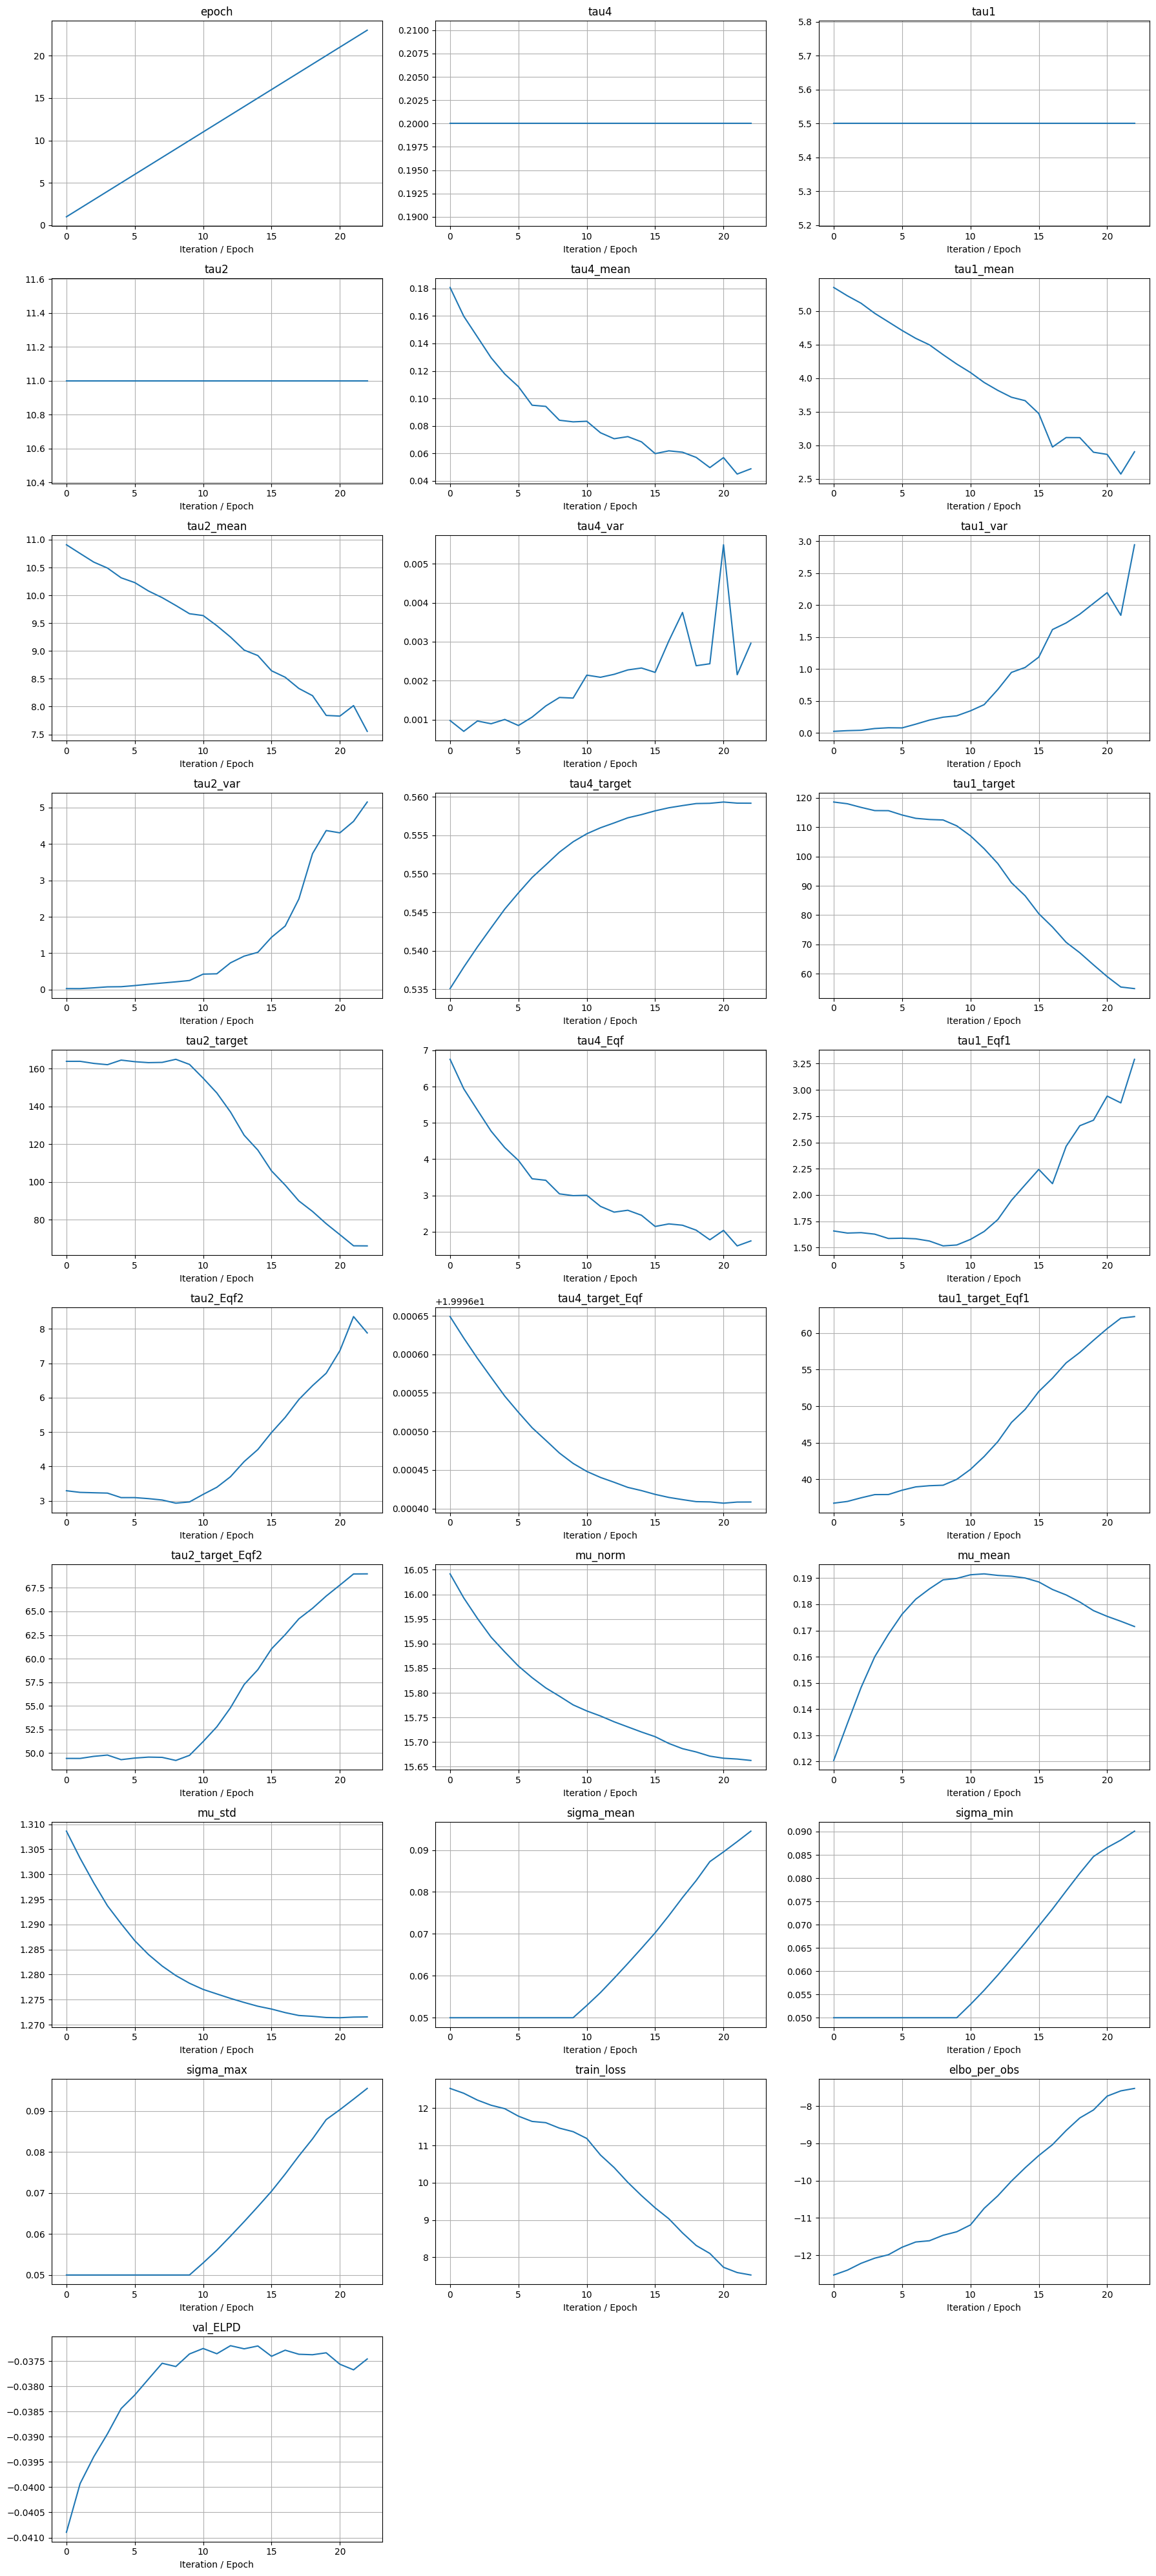

In [22]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
output["monitor"].keys()

dict_keys(['epoch', 'tau4', 'tau1', 'tau2', 'tau4_mean', 'tau1_mean', 'tau2_mean', 'tau4_var', 'tau1_var', 'tau2_var', 'tau4_target', 'tau1_target', 'tau2_target', 'tau4_Eqf', 'tau1_Eqf1', 'tau2_Eqf2', 'tau4_target_Eqf', 'tau1_target_Eqf1', 'tau2_target_Eqf2', 'mu_norm', 'mu_mean', 'mu_std', 'sigma_mean', 'sigma_min', 'sigma_max', 'train_loss', 'elbo_per_obs', 'val_ELPD'])

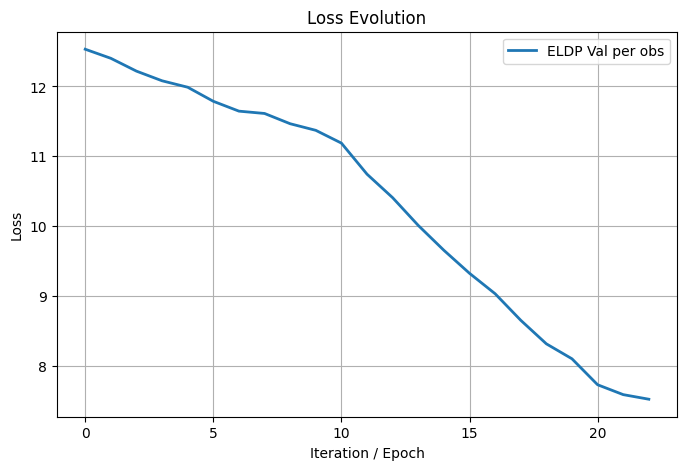

In [23]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [24]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [25]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [26]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0545
KLD GTM      Train Data:  0.0081
KLD Gaussian Train Data:  0.0994
KLD Copula   Train Data:  -0.0005

KLD BGTM      Test  Data:  0.0718
KLD GTM      Test  Data:  0.0182
KLD Gaussian Test  Data:  0.1068
KLD Copula   Test  Data:  0.0123


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [27]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

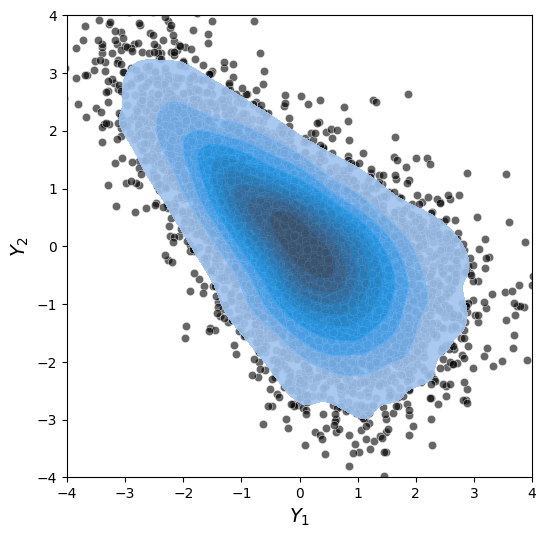

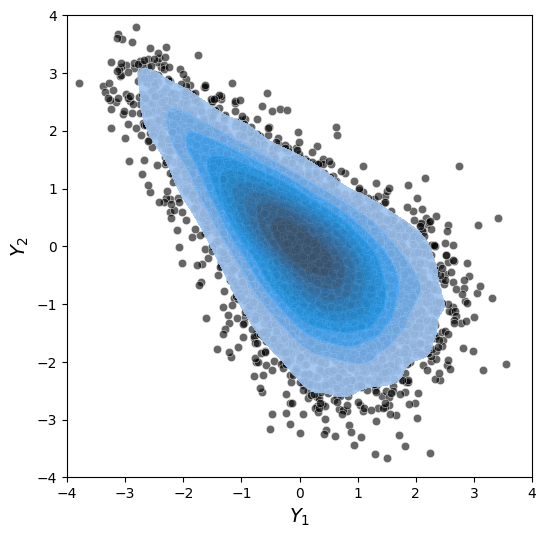

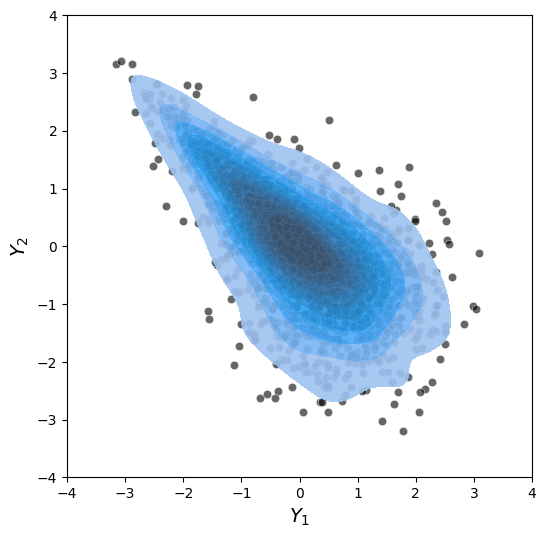

In [28]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [19]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [20]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


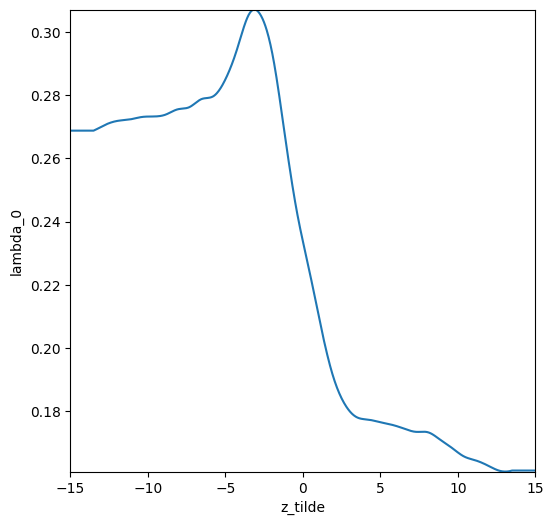

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


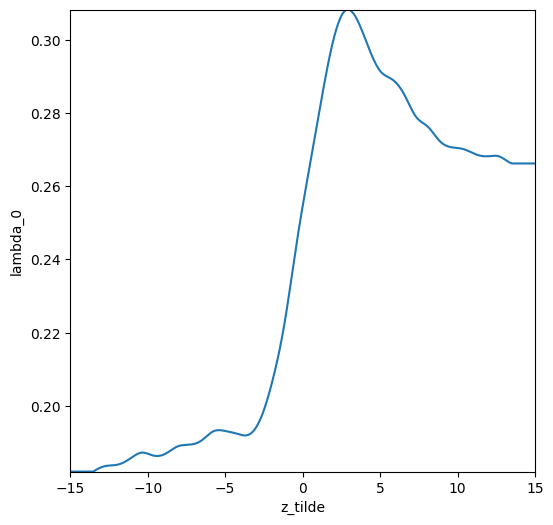

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


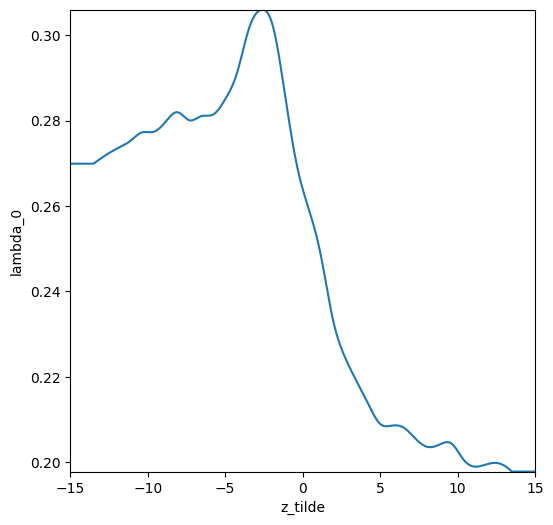

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)